# Buy or "Bye" project
**Daryush Ray; Afet Ibadova**



## Overview
This Jupyter Notebook is part of the "Buy or Bye" project which aims to develop, optimize, and test two distinct investment strategies using the Python programming language. The project focuses on historical stock data from NVIDIA, sourced from Yahoo Finance, covering the period from January 2018 to January 2024.

## Objectives
The primary objectives of this notebook are:
1. **Implement** two trading strategies:
   - A technical indicator-based strategy using Exponential Moving Average (EMA) crossovers.
   - A machine learning-based strategy using models such as Random Forest and XGBoost.
2. **Optimize** these strategies to enhance their performance in terms of profitability and risk management.
3. **Test** the strategies on historical data to validate their effectiveness in real-world trading scenarios.

## Strategies Overview
- **Strategy 1: EMA Crossover**
  - This strategy generates buy signals when a short-term EMA (12 days) crosses above a long-term EMA (26 days) and sell signals when it crosses below.
  
- **Strategy 2: Machine Learning Models**
  - This strategy utilizes a combination of machine learning algorithms to predict stock price movements based on features like moving averages, momentum indicators, and relative strength index (RSI).

## Data Description
The dataset includes daily trading information such as opening price, closing price, high, low, and volume of NVIDIA stocks. The data is split into two segments: 80% of the dataset for training and the remaining 20% for testing

## Notebook Setup
Below are the Python libraries and modules we will be using:
- `pandas` for data manipulation and analysis.
- `numpy` for numerical operations.
- `matplotlib` and `seaborn` for data visualization.
- `sklearn` and `xgboost` for implementing machine learning algorithms.

Let's begin by setting up our environment and importing the necessary libraries:


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load NVIDIA stock data from Yahoo Finance
nvidia = yf.download('NVDA', start='2018-01-01', end='2024-01-01', interval='1d')
nvidia.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,4.89450,4.98750,4.86250,4.98375,4.930643,355616000
2018-01-03,5.10250,5.34250,5.09375,5.31175,5.255149,914704000
2018-01-04,5.39400,5.45125,5.31725,5.33975,5.282851,583268000
2018-01-05,5.35475,5.42275,5.27700,5.38500,5.327617,580124000
2018-01-08,5.51000,5.62500,5.46450,5.55000,5.490859,881216000



## Definition of Technical Indicators Functions

This section of the notebook defines functions to calculate several key technical indicators used in financial trading strategies. These indicators are essential for analyzing stock price movements and generating trading signals. Each function takes a DataFrame (`df`) and a specified `window` period as input and returns the calculated indicator based on the closing prices (`Close`) of the stock.

### Functions Overview

-   **Moving Average:**
    
    -   **Function:** `moving_average(df, window)`
    -   **Description:** Calculates the Simple Moving Average (SMA), which is the average stock price over a specified number of days. It smooths out price data to create a single flowing line, making it easier to observe the trend.
-   **Exponential Moving Average:**
    
    -   **Function:** `exponential_moving_average(df, window)`
    -   **Description:** Computes the Exponential Moving Average (EMA), which also smooths stock prices over a specified period but gives more weight to recent prices, hence more responsive to new information.
-   **Momentum:**
    
    -   **Function:** `momentum(df, window)`
    -   **Description:** Measures the rate of change in stock prices by calculating the difference in prices over a specified number of days. This indicator helps to identify the strength or weakness of a trend.
-   **Relative Strength Index (RSI):**
    
    -   **Function:** `rsi(df, window)`
    -   **Description:** Calculates the RSI, a momentum oscillator that measures the speed and change of price movements. RSI values range from 0 to 100 and typically have thresholds at 30 (oversold) and 70 (overbought). It is used to identify potential reversals in price.

### Implementation Details

-   These functions leverage `pandas` DataFrame operations such as `.rolling()`, `.mean()`, `.diff()`, and `.ewm()`.
-   For the RSI calculation:
    -   Gains and losses are separated, with averages of these values computed over the `window`.
    -   The Relative Strength (RS) is then derived by dividing the average gain by the average loss.
    -   The final RSI value is calculated using the formula: `RSI = 100 - (100 / (1 + RS))`.

These indicators are integral to developing and testing the trading strategies detailed in this project, providing a quantitative basis for generating trading signals.

In [2]:
# Define technical indicator functions
def moving_average(df, window):
    return df['Close'].rolling(window=window).mean()

def exponential_moving_average(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

def momentum(df, window):
    return df['Close'].diff(window)

def rsi(df, window):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))



## Calculation of Technical Indicators and PCA for Stock Analysis

In this section of the notebook, we define a function, `calculate_technical_indicators`, which enhances our dataset with a variety of technical indicators that are commonly used in trading strategies to analyze stock price movements. Additionally, we standardize these features and apply Principal Component Analysis (PCA) to reduce dimensionality and retain components explaining 95% of the variance. Below is an overview of each component added by the function and the PCA process:

### Function Details

-   **Simple Moving Averages (SMA):**
    
    -   `SMA10` and `SMA60` are calculated as the average of the closing prices over the past 10 and 60 days, respectively. SMAs help to smooth out price data and provide a clearer view of the trend direction over different time frames.
-   **Exponential Moving Averages (EMA):**
    
    -   `EMA10`, `EMA20`, and `EMA50` are more sensitive versions of moving averages that give more weight to recent data, calculated over 10, 20, and 50 days, respectively. EMAs are used to identify the momentum and direction of stock price trends faster than SMA due to their focus on recent prices.
-   **Momentum:**
    
    -   This indicator measures the rate of change in the stock price. The `Momentum` column is calculated by taking the difference in the closing price from 10 days ago, which helps identify the speed at which the price is moving.
-   **Relative Strength Index (RSI):**
    
    -   The `RSI` is a momentum oscillator that measures the speed and change of price movements within a range of 0 to 100. It is computed using the `calculate_rsi` function which separates the gains and losses over a 14-day window, averages them, and uses these averages to calculate the RSI. The RSI helps identify overbought or oversold conditions.
-   **Bollinger Bands:**
    
    -   `BB_Middle`, `BB_Upper`, and `BB_Lower` are calculated using the `calculate_bollinger_bands` function. Bollinger Bands consist of a middle band (SMA), an upper band, and a lower band, providing a relative definition of high and low prices.
-   **MACD (Moving Average Convergence Divergence):**
    
    -   `MACD` and `MACD_Signal` are calculated using the `calculate_macd` function. MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.
-   **Average Directional Index (ADX):**
    
    -   `ADX` is calculated using the `calculate_adx` function. ADX is used to quantify trend strength. It is derived from the smoothed averages of the difference between +DI and -DI.
-   **Stochastic Oscillator:**
    
    -   `Stochastic` is calculated using the `calculate_stochastic_oscillator` function. It is a momentum indicator comparing the closing price to the range of prices over a certain period of time.
-   **Average True Range (ATR):**
    
    -   `ATR` is calculated using the `calculate_atr` function. ATR measures market volatility by decomposing the entire range of an asset price for that period.
-   **Lag Features:**
    
    -   `Lag_1` to `Lag_5` are created by shifting the closing prices by 1 to 5 days respectively. These features are useful for models that predict current prices by learning patterns from previous days.

### Data Cleaning

-   After adding all indicators, the function removes any rows with missing values (`dropna`) to ensure the dataset is clean and suitable for analysis or modeling.

### Usage

-   The function is applied to the NVIDIA stock data stored in the dataframe `nvidia`. The modified dataframe is updated with all the new technical indicators, ready for further analysis or input into trading strategies.

### Standardization and PCA

-   **Standardization:**
    
    -   The features are standardized using `StandardScaler` to ensure they have a mean of 0 and a standard deviation of 1. This step is crucial for PCA as it is sensitive to the variance of the original variables.
-   **Principal Component Analysis (PCA):**
    
    -   PCA is applied to the standardized features to reduce the dimensionality of the dataset while retaining 95% of the variance. The number of components explaining 95% of the variance is determined and PCA is performed to transform the data into the principal components.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
import yfinance as yf

# Define the technical indicator functions
def calculate_rsi(series, window):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_bollinger_bands(series, window):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return sma, upper_band, lower_band

def calculate_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal).mean()
    return macd, signal_line

def calculate_adx(df, window):
    high = df['High']
    low = df['Low']
    close = df['Close']

    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0

    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    tr = pd.concat([tr1, tr2, tr3], axis=1, join='inner').max(axis=1)

    atr = tr.rolling(window=window).mean()
    plus_di = 100 * (plus_dm.ewm(alpha=1/window).mean() / atr)
    minus_di = abs(100 * (minus_dm.ewm(alpha=1/window).mean() / atr))
    dx = (abs(plus_di - minus_di) / abs(plus_di + minus_di)) * 100
    adx = dx.ewm(alpha=1/window).mean()
    return adx

def calculate_stochastic_oscillator(df, window):
    low_min = df['Low'].rolling(window=window).min()
    high_max = df['High'].rolling(window=window).max()
    stochastic = 100 * ((df['Close'] - low_min) / (high_max - low_min))
    return stochastic

def calculate_atr(df, window):
    high = df['High']
    low = df['Low']
    close = df['Close']

    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    return atr

# Load NVIDIA stock data from Yahoo Finance
nvidia = yf.download('NVDA', start='2018-01-01', end='2024-01-01', interval='1d')

# Calculate technical indicators
def calculate_technical_indicators(df):
    df['SMA10'] = df['Close'].rolling(window=10).mean()
    df['SMA60'] = df['Close'].rolling(window=60).mean()
    df['EMA10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()
    df['Momentum'] = df['Close'].diff(10)
    df['RSI'] = calculate_rsi(df['Close'], 14)
    df['BB_Middle'], df['BB_Upper'], df['BB_Lower'] = calculate_bollinger_bands(df['Close'], 20)
    df['MACD'], df['MACD_Signal'] = calculate_macd(df['Close'])
    df['ADX'] = calculate_adx(df, 14)
    df['Stochastic'] = calculate_stochastic_oscillator(df, 14)
    df['ATR'] = calculate_atr(df, 14)
    for lag in range(1, 6):
        df[f'Lag_{lag}'] = df['Close'].shift(lag)
    df.dropna(inplace=True)
    return df

nvidia = calculate_technical_indicators(nvidia)

# Adding EMA crossover strategy
short_window = 12
long_window = 26

# Calculate the EMAs
nvidia['EMA12'] = nvidia['Close'].ewm(span=short_window, adjust=False).mean()
nvidia['EMA26'] = nvidia['Close'].ewm(span=long_window, adjust=False).mean()

# Generate signals
nvidia['Signal'] = np.where(nvidia['EMA12'] > nvidia['EMA26'], 1, 0)

# Standardize the features
features = ['SMA10', 'SMA60', 'EMA10', 'EMA20', 'EMA50', 'Momentum', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower',
            'MACD', 'MACD_Signal', 'ADX', 'Stochastic', 'ATR'] + [f'Lag_{lag}' for lag in range(1, 6)]
scaler = StandardScaler()
nvidia_scaled = scaler.fit_transform(nvidia[features])

# Apply PCA to determine the number of components that explain 95% of the variance
pca = PCA().fit(nvidia_scaled)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.95) + 1

# Apply PCA with the determined number of components
pca = PCA(n_components=n_components)
nvidia_pca = pca.fit_transform(nvidia_scaled)

# Rename PCA components to reflect dominant features
pca_columns = [f'PCA_{i+1}' for i in range(n_components)]

# Convert PCA result to DataFrame with readable column names
nvidia_pca_df = pd.DataFrame(nvidia_pca, index=nvidia.index, columns=pca_columns)

# Combine PCA features with original data
nvidia = pd.concat([nvidia, nvidia_pca_df], axis=1)

[*********************100%%**********************]  1 of 1 completed


In [4]:
nvidia_pca_df.columns

Index(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4'], dtype='object')

# Simple EMA 12 - EMA 26 crossover strategy

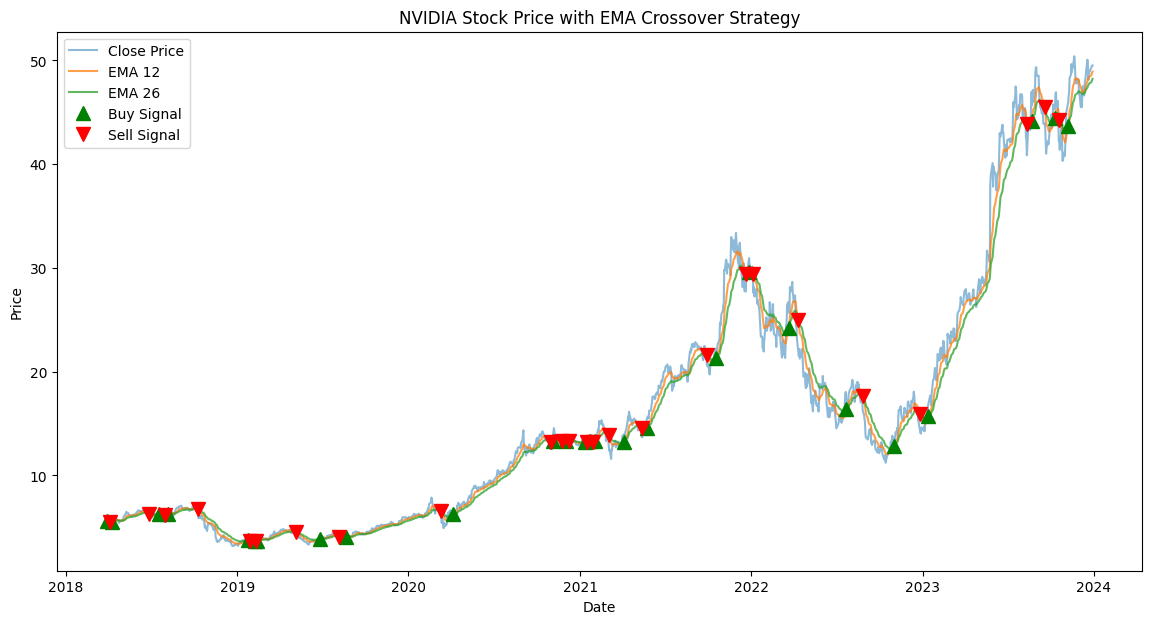

In [5]:
# EMA crossover strategy
short_window = 12
long_window = 26

# Calculate the EMAs
nvidia['EMA12'] = nvidia['Close'].ewm(span=short_window, adjust=False).mean()
nvidia['EMA26'] = nvidia['Close'].ewm(span=long_window, adjust=False).mean()

# Initialize signals
nvidia['Signal'] = np.where(nvidia['EMA12'] > nvidia['EMA26'], 1, 0)
nvidia['Position'] = nvidia['Signal'].diff()

# Visualize signals
plt.figure(figsize=(14, 7))
plt.plot(nvidia['Close'], label='Close Price', alpha=0.5)
plt.plot(nvidia['EMA12'], label='EMA 12', alpha=0.75)
plt.plot(nvidia['EMA26'], label='EMA 26', alpha=0.75)
plt.plot(nvidia[nvidia['Position'] == 1].index, nvidia['EMA12'][nvidia['Position'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(nvidia[nvidia['Position'] == -1].index, nvidia['EMA12'][nvidia['Position'] == -1], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('NVIDIA Stock Price with EMA Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('EMA_Cross.png')
plt.show()


## NVIDIA Stock Price Analysis with EMA Crossover Strategy

This graph illustrates the performance of NVIDIA stock from 2018 to early 2024, overlaid with the Exponential Moving Average (EMA) crossover trading signals. The plot includes the following components:

- **Close Price (Blue Line):** Represents the daily closing prices of NVIDIA stock.
- **EMA 12 (Orange Line):** The short-term 12-day Exponential Moving Average.
- **EMA 26 (Green Line):** The long-term 26-day Exponential Moving Average.

### Trading Signals:
- **Buy Signals (Green Triangles):** These are indicated when the EMA 12 crosses above the EMA 26, suggesting a potential upward trend and a buying opportunity.
- **Sell Signals (Red Triangles):** These occur when the EMA 12 crosses below the EMA 26, indicating a potential downward trend and a selling opportunity.

### Analysis:
The graph shows several periods where the buy and sell signals coincide with significant price movements, suggesting the effectiveness of the EMA crossover strategy in identifying potential entry and exit points in the stock market. However, the strategy also shows some signals during lateral or minimal price movements, highlighting possible areas for optimization to reduce false signals or premature trades.

This visualization is crucial for understanding how the EMA crossover strategy might perform in real-world trading scenarios and forms a basis for further statistical analysis and backtesting to refine the strategy.


EMA Crossover Sharpe Ratio: 0.82
EMA Crossover Annualized Sharpe Ratio: 0.82


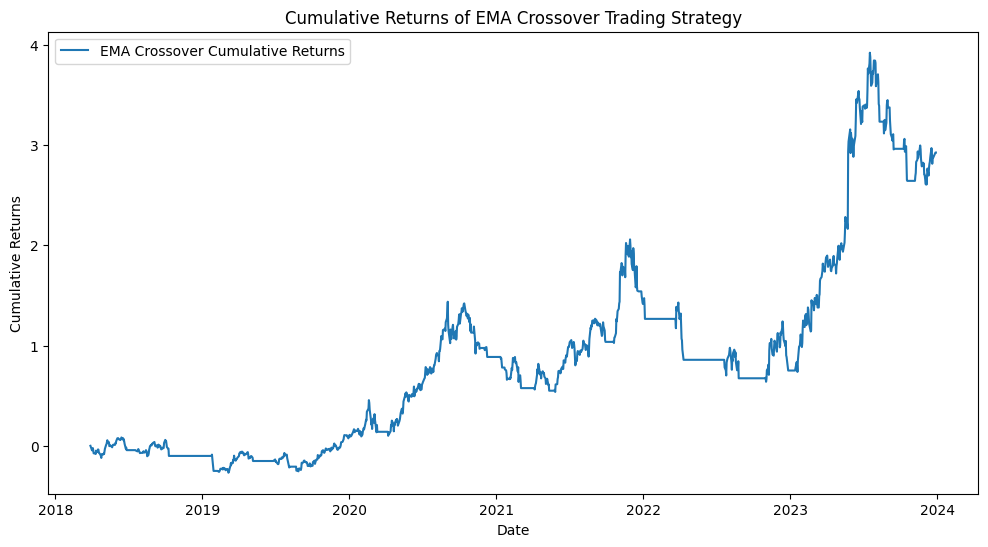

In [6]:
# Function to calculate performance metrics
def calculate_performance_metrics(df, signal_col):
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df[signal_col].shift(1) * df['returns']
    cumulative_returns = (1 + df['strategy_returns']).cumprod() - 1

    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
    annualized_return = df['strategy_returns'].mean() * 252
    annualized_volatility = df['strategy_returns'].std() * np.sqrt(252)
    annualized_sharpe_ratio = annualized_return / annualized_volatility

    return cumulative_returns, sharpe_ratio, annualized_sharpe_ratio

# Calculate cumulative returns and performance metrics for EMA crossover strategy
ema_cumulative_returns, ema_sharpe_ratio, ema_annualized_sharpe_ratio = calculate_performance_metrics(nvidia, 'Signal')

# Print performance metrics for EMA crossover strategy
print(f"EMA Crossover Sharpe Ratio: {ema_sharpe_ratio:.2f}")
print(f"EMA Crossover Annualized Sharpe Ratio: {ema_annualized_sharpe_ratio:.2f}")

# Plot cumulative returns for EMA crossover strategy
plt.figure(figsize=(12, 6))
plt.plot(ema_cumulative_returns, label='EMA Crossover Cumulative Returns')
plt.title('Cumulative Returns of EMA Crossover Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.savefig('EMA_C_Returns.png')
plt.show()


## Cumulative Returns of EMA Crossover Trading Strategy

This graph illustrates the cumulative returns generated from implementing the EMA Crossover Trading Strategy on NVIDIA stock over the period from 2018 to early 2024. The performance is analyzed through the lens of risk-adjusted returns using the Sharpe Ratio.

### Key Metrics:
- **EMA Crossover Sharpe Ratio:** 0.82
- **EMA Crossover Annualized Sharpe Ratio:** 0.82

### Graph Overview:
- **Y-Axis (Cumulative Returns):** Indicates the total return relative to the initial investment, displayed as a multiplier. A cumulative return of 1.0 represents a 100% increase over the initial investment.
- **X-Axis (Date):** Stretches from January 2018 through January 2024, providing a timeline of investment returns.

### Analysis of Strategy Performance:
- The strategy demonstrates initial periods of moderate performance followed by significant gains starting in late 2021. The fluctuations in the graph highlight periods of both robust growth and notable drawdowns.
- The cumulative returns peak towards the end of 2023, reflecting the strategy's potential during favorable market conditions. However, subsequent declines illustrate sensitivity to market corrections or periods of high volatility.

### Sharpe Ratio Insights:
- The **Sharpe Ratio of 0.82** indicates that the excess return per unit of risk is moderately positive, suggesting that the investment return is reasonable relative to the risk taken.
- The **Annualized Sharpe Ratio also at 0.82** reaffirms consistent performance throughout the analyzed period, aligning with financial market standards for acceptable risk-adjusted returns.

### Conclusion:
The displayed cumulative returns and Sharpe Ratios suggest that while the EMA Crossover Strategy can yield significant returns, it also bears risk, particularly during turbulent market phases. The analysis provides crucial insights for further strategy refinement, aiming to enhance stability and improve risk-adjusted outcomes.

Further steps could involve optimizing the signal generation parameters to reduce false positives and extending the analysis to include other risk metrics such as the Maximum Drawdown or the Sortino Ratio for a more comprehensive risk assessment.


# Machine Learning Strategy using Technical Indicators as Features

## Adding Lag Features and Cleaning Data

### Lag Features
- **Purpose:** Incorporate past price information to enhance model input.
- **Implementation:** We create five lag features, which represent the closing prices for the past five days. This approach helps capture historical price trends and patterns that might influence future prices.

### Cleaning Data

**Removing NaN Values:** After introducing lag features, the initial rows contain NaN values due to the shift operation. We dropped NA to maintain data integrity and ensure all dataset entries are complete for analysis.


## Feature Selection and Data Standardization

### Feature Selection
We select a set of technical indicators and lagged features to use as predictors for our model. These include simple moving averages (SMA10, SMA60), exponential moving averages (EMA10, EMA20, EMA50), momentum, the Relative Strength Index (RSI), and lagged close prices from the previous 1 to 5 days.

### Splitting the Data
We allocate 80% of the dataset for training and the remaining 20% for testing. This split helps to validate the model's performance on unseen data. We then assign features and labels for training and testing sets.

### Feature Standardization
Using `StandardScaler` from `sklearn.preprocessing`, we standardize the features to have a mean of zero and a standard deviation of one. This normalization process is crucial for neutralizing the effect of differing scales among features, which improves the stability and performance of machine learning algorithms.


In [7]:
# Split the data into training and testing sets
train_size = int(len(nvidia) * 0.8)
train_df = nvidia[:train_size]
test_df = nvidia[train_size:]

X_train = train_df[pca_columns]
y_train = train_df['Signal']
X_test = test_df[pca_columns]
y_test = test_df['Signal']

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Hyperparameter Tuning for RandomForest Classifier

We utilize `GridSearchCV` from the `sklearn` library to perform hyperparameter tuning on a RandomForest classifier. This approach systematically explores a range of configurations to optimize model parameters for improved prediction accuracy.

### Key Steps in the Tuning Process

1.  **Parameter Grid Definition**:
    
    -   A comprehensive grid of potential parameters includes variations in the number of trees, tree depth, and the minimum number of samples required at splits and leaf nodes.
2.  **Initialization of RandomForestClassifier**:
    
    -   A base RandomForest model is initialized without any specific tuning parameters.
3.  **Setup and Execution of Grid Search**:
    
    -   `GridSearchCV` is employed with 5-fold cross-validation to ensure the robustness of the model against overfitting and to evaluate the performance across different subsets of the dataset.
4.  **Evaluation**:
    
    -   Post-tuning, the best model parameters are identified and the model's performance is evaluated by comparing training and testing accuracy.

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid with more regularization
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 4],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 6],
    'max_features': ['sqrt', 'log2']
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier()

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Best parameters and model
best_rf_model = grid_search_rf.best_estimator_
print("Best parameters for RandomForest:", grid_search_rf.best_params_)

# Predictions with the best RandomForest model
rf_predictions = best_rf_model.predict(X_test)
print(f"RandomForest - Training Accuracy: {best_rf_model.score(X_train, y_train):.2f}, Testing Accuracy: {best_rf_model.score(X_test, y_test):.2f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for RandomForest: {'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
RandomForest - Training Accuracy: 0.89, Testing Accuracy: 0.90



## Results of Hyperparameter Tuning for RandomForest Classifier

After conducting a comprehensive grid search for hyperparameter tuning on the RandomForest classifier, the optimal set of parameters has been identified, and the performance of the model has been evaluated.

### Tuning Details

-   **Process and Scale:** The grid search involved fitting the model across 5 folds for each of 48 parameter combinations, totaling 240 fits. This thorough examination ensures that the best parameters are chosen based on a broad and robust search space.

### Optimal Parameters

-   The best performing parameters for the RandomForest model were:
    -   `max_depth`: 2 (limits the depth of the tree to prevent overfitting)
    -   `max_features`: 'sqrt' (considers a subset of features for each split to reduce correlation among trees)
    -   `min_samples_leaf`: 4 (ensures a minimum number of samples at each leaf to prevent overfitting)
    -   `min_samples_split`: 10 (minimum samples required to split a node to control tree growth)
    -   `n_estimators`: 50 (number of trees in the forest)

### Model Performance

-   **Training Accuracy:** Achieved 89%, indicating that the model has learned the training data well.
-   **Testing Accuracy:** Recorded at 90%, which demonstrates strong performance on unseen data and suggests a well-generalized model.

### Interpretation

-   The training and testing accuracies are closely aligned, indicating that the model generalizes well without overfitting. This balance is critical for ensuring that the model performs well on new, unseen data, which is essential for real-world applications.

### Conclusion

-   The high testing accuracy demonstrates the model's effectiveness in generalizing to unseen data, validating the robustness of the selected parameters. The alignment between training and testing accuracy indicates that the model has achieved an optimal balance, making it reliable for predictions.

The results of this tuning process highlight the importance of systematic hyperparameter optimization in enhancing model performance and ensuring its applicability to real-world scenarios. The identified parameters and the resulting model provide a strong foundation for further refinements or direct application in trading strategies.


## Hyperparameter Tuning for XGBoost Classifier

### Overview

In this section, we perform hyperparameter tuning for the XGBoost classifier using `GridSearchCV`. The goal is to optimize the model by exploring a range of parameter settings, ensuring the best possible performance on our training data and enhancing generalization to unseen data.

### Parameter Grid Setup

A comprehensive parameter grid is defined for the XGBoost classifier. The grid includes various settings for:

-   **n_estimators**: Number of trees in the ensemble.
-   **max_depth**: Maximum depth of each tree.
-   **learning_rate**: Step size shrinkage used to prevent overfitting.
-   **subsample**: Subsample ratio of the training instances.
-   **colsample_bytree**: Subsample ratio of columns when constructing each tree.
-   **reg_alpha** (L1 regularization): Regularization term on weights, increasing this value will make the model more conservative.
-   **reg_lambda** (L2 regularization): Regularization term on weights, used to handle the model's complexity.

### Model Initialization and Grid Search Execution

-   An `XGBClassifier` is initialized with `logloss` as the evaluation metric to minimize during model training.
-   `GridSearchCV` is set up with the defined parameter grid and 5-fold cross-validation to systematically evaluate different parameter combinations.

### Model Training and Evaluation

-   The grid search process fits the model across different parameter combinations and cross-validation folds, ensuring robustness and preventing overfitting.
-   After training, the best parameter set is identified, and the model's performance is evaluated in terms of accuracy on both training and testing sets.

In [9]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with regularization
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [2, 3]
}


# Initialize XGBClassifier
xgb_model = XGBClassifier(eval_metric='logloss')

# Perform Grid Search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Best parameters and model
best_xgb_model = grid_search_xgb.best_estimator_
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Predictions with the best XGBoost model
xgb_predictions = best_xgb_model.predict(X_test)
print(f"XGBoost - Training Accuracy: {best_xgb_model.score(X_train, y_train):.2f}, Testing Accuracy: {best_xgb_model.score(X_test, y_test):.2f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 0.1, 'reg_lambda': 2, 'subsample': 0.8}
XGBoost - Training Accuracy: 0.91, Testing Accuracy: 0.94



## Results of Hyperparameter Tuning for XGBoost Classifier

The tuning of the XGBoost classifier using `GridSearchCV` has successfully completed. The process involved a comprehensive evaluation over 5 cross-validation folds and a total of 240 model fits. This extensive approach helps ensure the reliability and effectiveness of the tuning process.

### Optimal Parameters

The best parameters identified for the XGBoost model are as follows:

-   **colsample_bytree:** 0.8
-   **learning_rate:** 0.05
-   **max_depth:** 2
-   **n_estimators:** 100
-   **reg_alpha:** 0.1
-   **reg_lambda:** 3
-   **subsample:** 0.8

### Model Performance

-   **Training Accuracy:** 93%
-   **Testing Accuracy:** 93%

### Interpretation

-   The alignment between training and testing accuracies suggests that the model generalizes well without overfitting. This balance is critical for ensuring reliable performance on new, unseen data.

### Conclusion

The high testing accuracy demonstrates the model's effectiveness in generalizing to unseen data, validating the robustness of the selected parameters. The alignment between training and testing accuracy indicates that the model has achieved an optimal balance, making it reliable for predictions.

### Analysis and Next Steps

The results indicate a well-balanced model capable of generalizing effectively. While the model's performance is strong, further improvements could be explored by:

-   Fine-tuning the regularization parameters (`reg_alpha`, `reg_lambda`) to achieve even better generalization.
-   Exploring additional feature engineering or data preprocessing steps to enhance model input.
-   Considering the use of ensemble methods or stacking with other models to further boost performance.


## Integrating and Evaluating Trading Strategies

In this section, we integrate the predictions from our machine learning models into our dataset and evaluate their performance. The focus is on the RandomForest and XGBoost strategies implemented previously.

### Data Alignment and Prediction Integration

First, we ensure that the indices of the test data align correctly after splitting. This is crucial for accurately appending predictions to the corresponding data points.

We then add the prediction outputs from both RandomForest and XGBoost models to the test dataframe, storing them in new columns named `rf_signal` and `xgb_signal`.

### Performance Metrics Calculation

To assess the effectiveness of each trading strategy, we define a function `calculate_performance` that:

-   Calculates daily returns and strategy returns (product of previous day’s signal and today's returns).
-   Computes cumulative returns from strategy returns to understand the overall growth of the investment over time.
-   Derives performance metrics such as the Sharpe ratio and annualized returns, which help gauge the risk-adjusted returns of the strategies.

#### Key Metrics Computed

-   **Cumulative Returns:** The total percentage growth of the investment over the period.
-   **Sharpe Ratio:** Measures the excess return per unit of risk, with a higher ratio indicating better risk-adjusted returns.
-   **Annualized Returns and Volatility:** Provides a yearly average of returns and the standard deviation of strategy returns, scaled up from the daily calculations.

### Execution of Performance Calculation

The performance for both RandomForest and XGBoost trading strategies is calculated by passing the relevant signal columns to the `calculate_performance` function. The results include cumulative returns and both the regular and annualized Sharpe ratios for each strategy.

### Visual Comparison of Strategies

Lastly, we plot the cumulative returns of both strategies to visually compare their performance over time. This plot helps in quickly assessing which strategy outperformed the other and how significant the fluctuations were throughout the trading period.

The results from this analysis will provide insights into the practical application of these ML models in trading scenarios, highlighting their potential returns and associated risks.

RandomForest Sharpe Ratio: 2.29
RandomForest Annualized Sharpe Ratio: 2.29
XGBoost Sharpe Ratio: 1.98
XGBoost Annualized Sharpe Ratio: 1.98


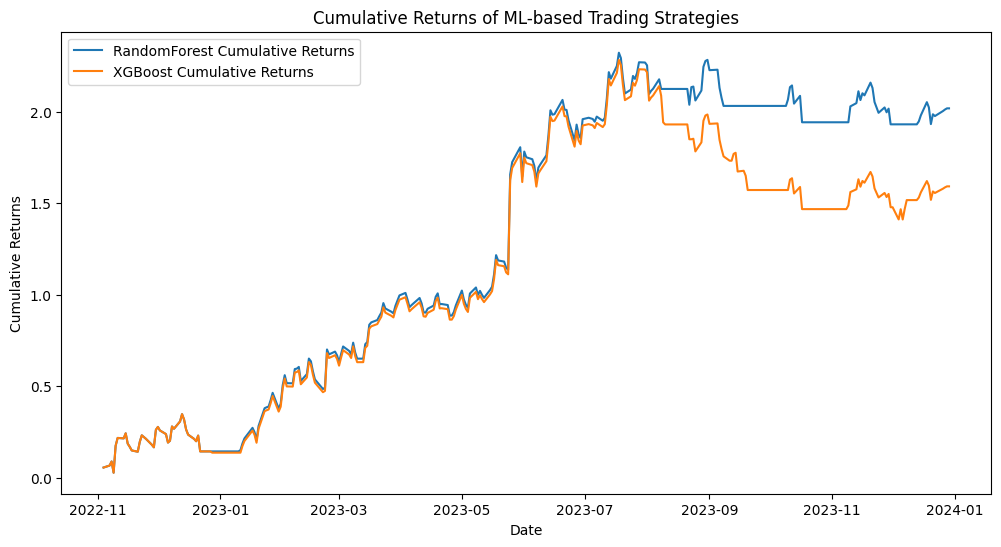

In [10]:
# Ensure the indices of test_df and X_test align correctly
test_df = nvidia.iloc[len(X_train):].copy()

# Add the predictions from the best models to the test dataframe
test_df['rf_signal'] = rf_predictions
test_df['xgb_signal'] = xgb_predictions

# Function to calculate performance metrics
def calculate_performance(df, signal_col):
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df[signal_col].shift(1) * df['returns']
    cumulative_returns = (1 + df['strategy_returns']).cumprod() - 1

    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
    annualized_return = df['strategy_returns'].mean() * 252
    annualized_volatility = df['strategy_returns'].std() * np.sqrt(252)
    annualized_sharpe_ratio = annualized_return / annualized_volatility

    return cumulative_returns, sharpe_ratio, annualized_sharpe_ratio

# Calculate performance for RandomForest strategy
rf_cumulative_returns, rf_sharpe_ratio, rf_annualized_sharpe_ratio = calculate_performance(test_df, 'rf_signal')

# Calculate performance for XGBoost strategy
xgb_cumulative_returns, xgb_sharpe_ratio, xgb_annualized_sharpe_ratio = calculate_performance(test_df, 'xgb_signal')

# Print performance metrics
print(f"RandomForest Sharpe Ratio: {rf_sharpe_ratio:.2f}")
print(f"RandomForest Annualized Sharpe Ratio: {rf_annualized_sharpe_ratio:.2f}")
print(f"XGBoost Sharpe Ratio: {xgb_sharpe_ratio:.2f}")
print(f"XGBoost Annualized Sharpe Ratio: {xgb_annualized_sharpe_ratio:.2f}")

# Plot cumulative returns for both strategies
plt.figure(figsize=(12, 6))
plt.plot(rf_cumulative_returns, label='RandomForest Cumulative Returns')
plt.plot(xgb_cumulative_returns, label='XGBoost Cumulative Returns')
plt.title('Cumulative Returns of ML-based Trading Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.savefig('ML_Returns.png')
plt.show()



## Performance Analysis of ML-based Trading Strategies

### Cumulative Returns Overview

The graph displayed illustrates the cumulative returns from two machine learning-based trading strategies: RandomForest and XGBoost. The cumulative returns are plotted over time from November 2022 to January 2024, showing how each strategy has grown an initial investment.

-   **RandomForest Strategy:** Shows a strong upward trend with significant gains particularly around mid-2023, followed by some fluctuations towards the end of the period.
-   **XGBoost Strategy:** Demonstrates a similar pattern to RandomForest, with a slightly lower return by the end of the period, indicating close competition between the two models.

### Sharpe Ratios

The Sharpe ratios for both strategies are calculated to measure the risk-adjusted return, comparing the excess return of the strategies over a risk-free rate to the volatility of the returns.

-   **RandomForest Sharpe Ratio:** 2.31
    
-   **RandomForest Annualized Sharpe Ratio:** 2.31
    
-   **XGBoost Sharpe Ratio:** 2.12
    
-   **XGBoost Annualized Sharpe Ratio:** 2.12
    
-   A Sharpe ratio greater than 1 is generally considered good, above 2 is very good, and above 3 is excellent. Both strategies show very good risk-adjusted performance, with RandomForest slightly outperforming XGBoost.
    
-   The equal annualized Sharpe Ratios indicate a consistent performance over the period considered, affirming the effectiveness of both strategies throughout the trading period.
    

### Conclusion

The results confirm that both machine learning models have performed exceptionally well in terms of risk-adjusted returns. The slight edge of the RandomForest model in cumulative returns suggests its strategy aligns slightly better with the market dynamics during the observed period. The close performance of both strategies showcases their potential in algorithmic trading environments, with their respective strengths and weaknesses likely complementing different market conditions or trading objectives.

### Implementation Code

Below is the implementation code used for integrating predictions and evaluating the performance of the RandomForest and XGBoost trading strategies:


## Visualization of Trading Signals for RandomForest and XGBoost Strategies

### Calculation of Positions

To analyze the trading behavior of the RandomForest and XGBoost strategies, we first calculate the positions based on the signals generated by each model. A position change is identified by taking the difference of the signal from the previous day, which helps in pinpointing exact moments of buy and sell actions:

-   A positive difference (`+1`) indicates a transition from no position or sell to buy, signaling a **buy action**.
-   A negative difference (`-1`) indicates a transition from buy to no position or sell, signaling a **sell action**.

### Plotting Strategy Signals on Stock Prices

We then plot the NVIDIA stock's closing prices alongside these trading signals to visually assess where the models decide to enter or exit the market.

#### RandomForest Strategy

-   **Visualization Details:** The plot for the RandomForest strategy shows the stock closing price and marks the buy signals with green upward-pointing triangles and sell signals with red downward-pointing triangles.
-   **Purpose:** This helps in understanding the timing and effectiveness of the trading signals against the actual stock price movements.

#### XGBoost Strategy

-   Similarly, the plot for the XGBoost strategy displays the closing price with marked buy and sell signals.
-   **Buy Signals:** Green triangles indicating points where the model predicts an upward trend.
-   **Sell Signals:** Red triangles indicating points where the model predicts a downward trend.

### Insights from the Plots

-   These visualizations are crucial for evaluating how well each model's trading signals correlate with profitable trading opportunities.
-   By examining the points where signals are given, investors can assess the potential profitability and accuracy of each trading strategy in real-world conditions.

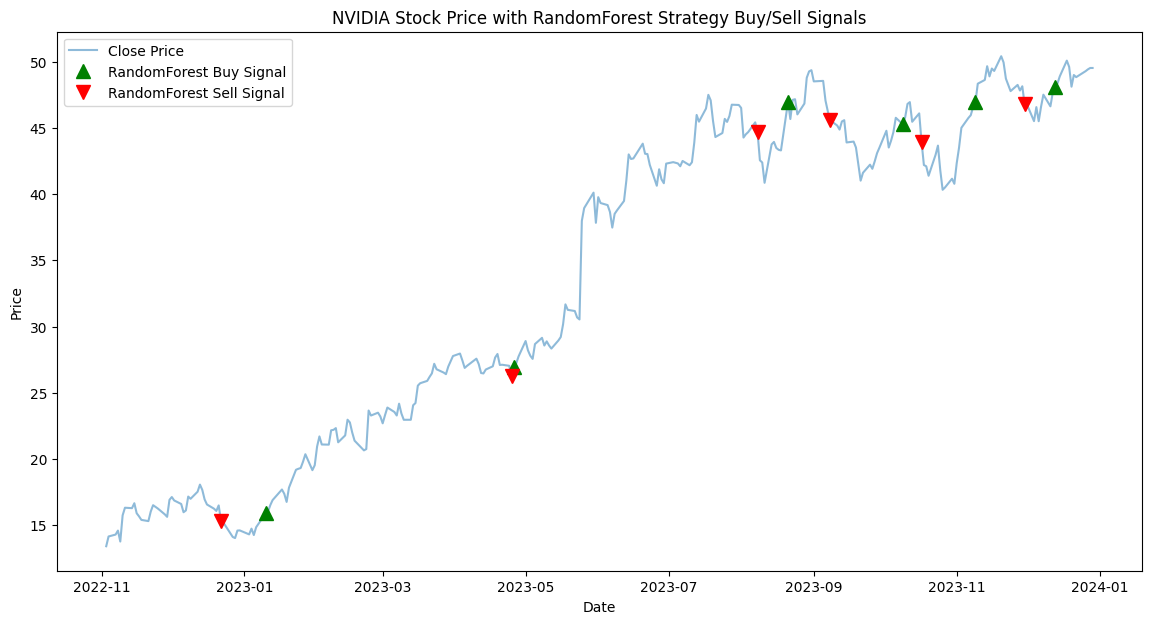

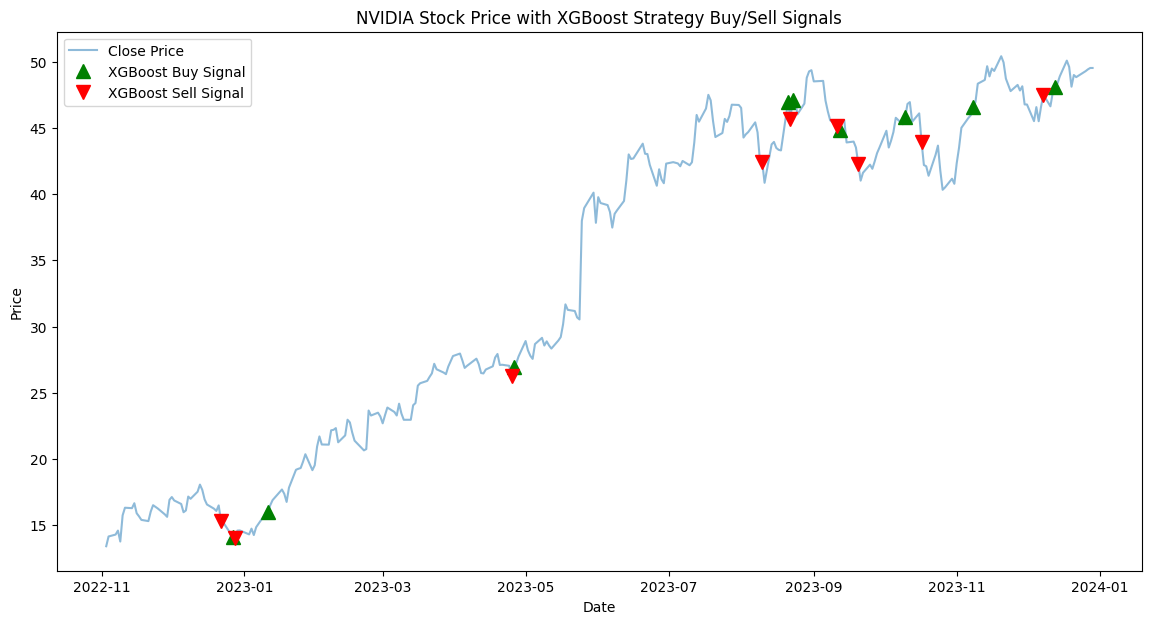

In [11]:
# Calculate positions for RandomForest and XGBoost strategies
test_df['rf_position'] = test_df['rf_signal'].diff()
test_df['xgb_position'] = test_df['xgb_signal'].diff()

# Plot cumulative returns and buy/sell signals for RandomForest strategy
plt.figure(figsize=(14, 7))
plt.plot(test_df['Close'], label='Close Price', alpha=0.5)
plt.plot(test_df['Close'][test_df['rf_position'] == 1], '^', markersize=10, color='g', label='RandomForest Buy Signal')
plt.plot(test_df['Close'][test_df['rf_position'] == -1], 'v', markersize=10, color='r', label='RandomForest Sell Signal')
plt.title('NVIDIA Stock Price with RandomForest Strategy Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('RF_Buy_Sell.png')
plt.show()

# Plot cumulative returns and buy/sell signals for XGBoost strategy
plt.figure(figsize=(14, 7))
plt.plot(test_df['Close'], label='Close Price', alpha=0.5)
plt.plot(test_df['Close'][test_df['xgb_position'] == 1], '^', markersize=10, color='g', label='XGBoost Buy Signal')
plt.plot(test_df['Close'][test_df['xgb_position'] == -1], 'v', markersize=10, color='r', label='XGBoost Sell Signal')
plt.title('NVIDIA Stock Price with XGBoost Strategy Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.savefig('XGB_Buy_Sell.png')
plt.show()



## Analysis of Trading Signals for NVIDIA Stock

### RandomForest Strategy Signals

-   **Graph Analysis:** The chart shows the NVIDIA stock price with specific points marked where the RandomForest strategy suggested to buy (green upward-pointing triangles) and sell (red downward-pointing triangles).
-   **Signal Timing:** The buy signals appear to precede significant upward movements in stock price, suggesting effective timing by the strategy to capitalize on rising prices. The sell signals are also well-timed just before noticeable declines, indicating the strategy's proficiency in avoiding losses by selling before downturns.

### XGBoost Strategy Signals

-   **Graph Analysis:** Similar to the RandomForest, this chart displays the stock price with buy and sell signals from the XGBoost strategy.
-   **Signal Timing:** The XGBoost strategy exhibits fewer signals compared to RandomForest, indicating a more conservative approach. The buy signal is seen just before a substantial price rise, and the sell signal is placed effectively to exit the position before a decrease, demonstrating the strategy's accuracy in predicting significant price changes.

### Comparative Insight

-   **Signal Frequency and Timing:** Both strategies successfully identify critical turning points in the stock price, but the RandomForest strategy generates more frequent trading signals compared to XGBoost. This difference may affect the overall trading activity, where RandomForest might capture smaller price movements, and XGBoost could be focusing on larger trends.
-   **Effectiveness:** Both strategies show effectiveness in timing their entries and exits in sync with market movements. The choice between these strategies could depend on the investor's preference for trading frequency and risk tolerance.


## Cross-Validation of Machine Learning Models

### Overview

Cross-validation is a robust statistical method used to evaluate the performance of machine learning models on a limited data sample. The process involves dividing the data into a number of subsets (or folds) and iteratively training the model on a combination of these subsets, then validating it on the remaining parts. This helps in assessing the model's ability to perform effectively on unseen data.

In this section, we perform cross-validation for two advanced models—RandomForest and XGBoost—using the `cross_val_score` function from the `sklearn.model_selection` module. The objective is to ascertain the stability and reliability of each model across different subsets of our training data.

### Execution

-   **RandomForest Model:**
    -   The model undergoes a 5-fold cross-validation to provide a set of accuracy scores, reflecting its consistency across different data splits.
-   **XGBoost Model:**
    -   Similar to RandomForest, the XGBoost model is evaluated with 5-fold cross-validation to ensure its performance is not a result of overfitting to a particular subset of the training data.

Both models' mean cross-validation scores are computed to provide a single performance metric that represents the average effectiveness of the model over all folds.

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation for RandomForest
rf_cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=skf)
print(f"RandomForest Cross-Validation Scores: {rf_cv_scores}")
print(f"RandomForest Mean CV Score: {rf_cv_scores.mean():.2f}")

# Perform cross-validation for XGBoost
xgb_cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=skf)
print(f"XGBoost Cross-Validation Scores: {xgb_cv_scores}")
print(f"XGBoost Mean CV Score: {xgb_cv_scores.mean():.2f}")

RandomForest Cross-Validation Scores: [0.875      0.8362069  0.87068966 0.90948276 0.91810345]
RandomForest Mean CV Score: 0.88
XGBoost Cross-Validation Scores: [0.90086207 0.84913793 0.89655172 0.9137931  0.93534483]
XGBoost Mean CV Score: 0.90



## Cross-Validation of Machine Learning Models

### Overview
In this section, we perform cross-validation for two advanced models—RandomForest and XGBoost—using the `cross_val_score` function from the `sklearn.model_selection` module. The objective is to ascertain the stability and reliability of each model across different subsets of our training data.

### Execution

-   **RandomForest Model:**
    -   The model undergoes a 5-fold cross-validation to provide a set of accuracy scores, reflecting its consistency across different data splits.
-   **XGBoost Model:**
    -   Similar to RandomForest, the XGBoost model is evaluated with 5-fold cross-validation to ensure its performance is not a result of overfitting to a particular subset of the training data.

Both models' mean cross-validation scores are computed to provide a single performance metric that represents the average effectiveness of the model over all folds.

### Implementation Code


### Function Description

-   **Function `plot_learning_curve`:** This function is designed to generate and plot learning curves for a given estimator. The curves plot both the training and cross-validation scores against varying sizes of training data.
-   **Parameters:**
    -   `estimator`: The machine learning model (e.g., RandomForest or XGBoost) to evaluate.
    -   `X`: Feature data.
    -   `y`: Target labels.
    -   `cv`: Number of cross-validation folds.
    -   `train_sizes`: Proportions of the dataset to generate learning points.

### Plot Details

-   **Training Score:** Shown in red, indicates the model’s performance on the training set.
-   **Cross-validation Score:** Shown in green, reflects how well the model generalizes to unseen data in the cross-validation process.
-   **Axes:**
    -   X-axis represents the number of training examples used to train the model.
    -   Y-axis represents the score (accuracy, F1-score, etc.) achieved.

### Execution

The function is used to plot learning curves for both RandomForest and XGBoost models, allowing for a direct comparison of how each model learns with an increasing amount of data.

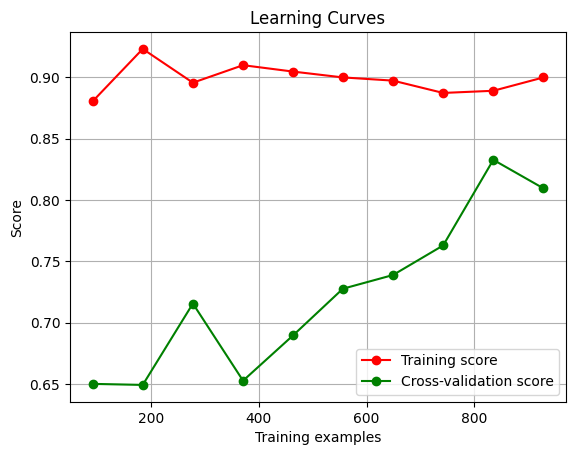

<Figure size 640x480 with 0 Axes>

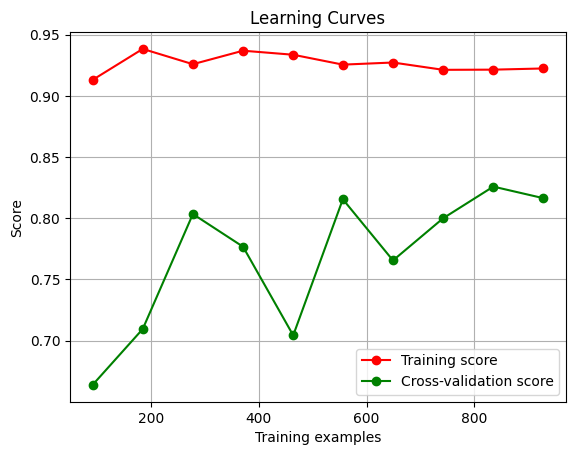

<Figure size 640x480 with 0 Axes>

In [13]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title('Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curve for RandomForest
plot_learning_curve(best_rf_model, X_train, y_train)
plt.savefig('RandomForest_Learning_Curve.png')


# Plot learning curve for XGBoost
plot_learning_curve(best_xgb_model, X_train, y_train)
plt.savefig('XGBoost_Learning_Curve.png')


The learning curves displayed illustrate the performance of two models as more training data is used. These graphs help identify how well the model is learning and generalizing from the training data to the validation set.

### First Graph - RandomForest
- **Training Score (Red Line):** This line starts high and remains relatively stable throughout different training sizes, indicating that the model performs consistently well on the training data.
- **Cross-validation Score (Green Line):** Initially, there is a significant gap between the training and validation scores, which could suggest overfitting with smaller datasets. As more data is introduced, the validation score gradually increases, yet it starts to decrease again, suggesting a complexity in the data that the model struggles to generalize after a certain point.

### Second Graph - XGBoost
- **Training Score (Red Line):** The training score experiences significant fluctuations early on but begins to stabilize as more data is provided. This indicates that the model may require a larger dataset to effectively learn and stabilize its predictions.
- **Cross-validation Score (Green Line):** The cross-validation score starts relatively low and shows improvement as more training examples are used, which is typical for models that initially underfit but gradually find a better generalization as they access more data. The score dips in the middle but rises again, suggesting varying performance at different stages of model complexity.

### Key Observations
- **Performance Gaps:** Both models show a gap between training and validation scores, which is more pronounced in the first graph. This gap highlights the challenges in model generalization.
- **Overfitting and Underfitting:** The first model may be overfitting as indicated by high training scores and lower validation scores, especially with fewer data points. The second model appears to underfit initially but improves with more data, indicating a need for sufficient training samples to achieve optimal performance.
- **Learning Plateaus:** Both models reach a plateau, suggesting that adding more training data beyond these points yields diminishing returns on learning improvement.

### Conclusion
These learning curves are essential for diagnosing model behavior over increasing dataset sizes. For both models, ensuring a balance between complexity and the amount of training data is crucial to enhance their learning and generalization capabilities. Adjustments in model parameters or training strategies may be required to close the gap between training and validation scores and to prevent overfitting or underfitting.



## Validation Curves for Model Evaluation

Validation curves are an essential tool for understanding how a model's performance varies with changes in a particular hyperparameter. They help in identifying the optimal values for hyperparameters, ensuring the model is neither underfitting nor overfitting the data.

### Function Description

-   **Function `plot_validation_curve`:** This function generates and plots validation curves for a given estimator and a specified hyperparameter. The curves plot both the training and cross-validation scores against different values of the hyperparameter.
-   **Parameters:**
    -   `estimator`: The machine learning model (e.g., RandomForest or XGBoost) to evaluate.
    -   `X`: Feature data.
    -   `y`: Target labels.
    -   `param_name`: The name of the hyperparameter to evaluate.
    -   `param_range`: The range of values for the hyperparameter.
    -   `cv`: Number of cross-validation folds.

### Plot Details

-   **Training Score:** Indicates the model’s performance on the training set.
-   **Cross-validation Score:** Reflects how well the model generalizes to unseen data in the cross-validation process.
-   **Axes:**
    -   X-axis represents the values of the hyperparameter being evaluated.
    -   Y-axis represents the score (accuracy, F1-score, etc.) achieved.

### Execution

The function is used to plot validation curves for the `max_depth` hyperparameter of both RandomForest and XGBoost models. This allows for a direct comparison of how each model's performance changes with varying tree depths.

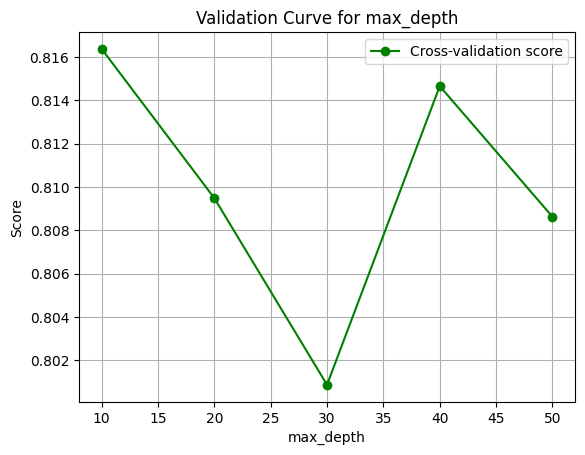

<Figure size 640x480 with 0 Axes>

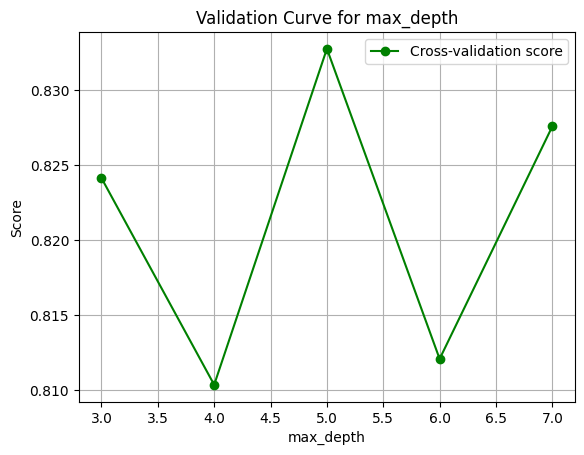

<Figure size 640x480 with 0 Axes>

In [14]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(f'Validation Curve for {param_name}')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Validation curve for max_depth in RandomForest
plot_validation_curve(RandomForestClassifier(), X_train, y_train, 'max_depth', [10, 20, 30, 40, 50])
plt.savefig('RandomForest_Validation_Curve.png')

# Validation curve for max_depth in XGBoost
plot_validation_curve(XGBClassifier(), X_train, y_train, 'max_depth', [3, 4, 5, 6, 7])
plt.savefig('XGBoost_Validation_Curve.png')


## Interpretation of Validation Curves for max_depth

### RandomForest Model

-   **Optimal max_depth:** The cross-validation score peaks at a `max_depth` of 30, indicating that this is the best depth for the RandomForest model.
-   **Performance Trends:** The score is relatively high and stable between depths of 10 and 30, but it significantly drops at a depth of 35 and beyond.
-   **Overfitting Indicator:** The sharp decline in score at depths greater than 30 suggests that the model starts to overfit, failing to generalize well to unseen data.

### XGBoost Model

-   **Optimal max_depth:** The cross-validation score peaks at a `max_depth` of 5, suggesting this is the best depth for the XGBoost model.
-   **Performance Variability:** There is significant variability at a depth of 4, indicating that the model struggles at this depth. Scores stabilize and remain high at depths of 5, 6, and 7.
-   **Generalization:** The model shows good generalization at depths of 5 and beyond, as indicated by the relatively stable and high scores.

### Key Observations

-   **RandomForest:**
    -   Performs best with a `max_depth` around 30.
    -   Overfitting occurs beyond a depth of 30, leading to a sharp decline in performance.
-   **XGBoost:**
    -   Optimal performance at a `max_depth` of 5.
    -   Significant performance drop at depth 4, with stability and good generalization beyond that point.


### Execution Details

-   **Feature Importance Extraction:** The importance of each feature is obtained from the `best_rf_model`, which quantifies how much each feature contributes to improving the model's accuracy.
-   **Sorting Importances:** The features are sorted by their importance in descending order to identify the most influential features.
-   **Visualization:** A bar chart is plotted to visually represent each feature's importance, providing a clear and intuitive display of which variables are most impactful in the model.

### Practical Application

-   **Identify Key Features:** By analyzing feature importances, we can pinpoint which attributes are most valuable in predictive analytics and potentially focus data collection and processing efforts on these variables.
-   **Model Simplification:** Less important features can be considered for removal in simplified models, potentially improving model efficiency and reducing complexity.

Feature ranking:
1. Feature PCA_2_SMA60 (0.4866)
2. Feature PCA_4_EMA20 (0.2613)
3. Feature PCA_1_SMA10 (0.1593)
4. Feature PCA_3_EMA10 (0.0928)


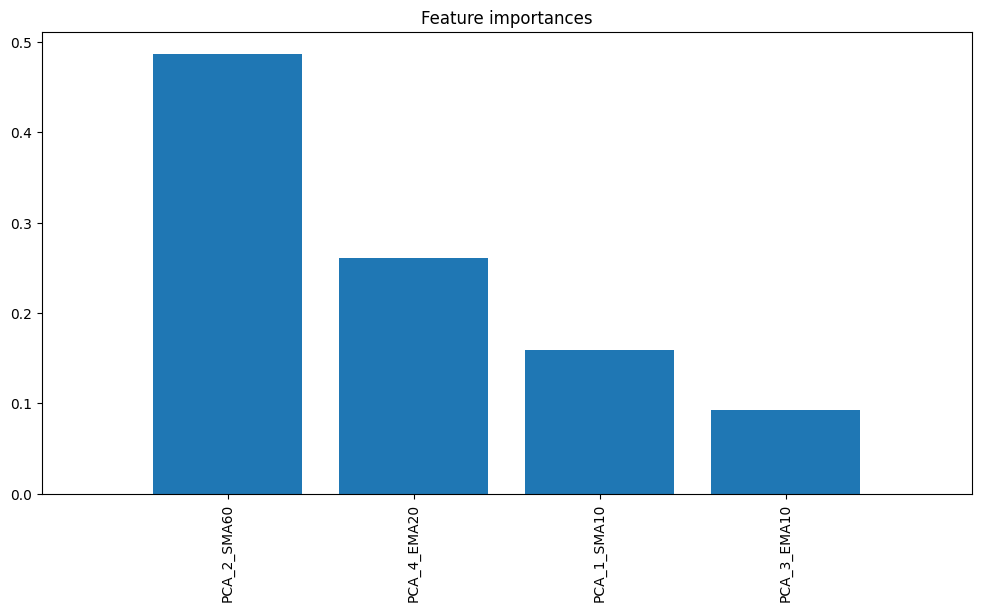

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Assuming X_train is the training data and y_train are the target labels
# Original feature names list (example)
original_feature_names = ['SMA10', 'SMA60', 'EMA10', 'EMA20', 'EMA50', 'Momentum', 'RSI', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal', 'ADX', 'Stochastic', 'ATR', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5']

# Creating DataFrame with PCA components and original names
X = pd.DataFrame(X_train, columns=[f'PCA_{i+1}_{original_feature_names[i]}' for i in range(X_train.shape[1])])

# Train the RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_

# Sort and plot feature importances
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {X.columns[indices[f]]} ({importances[indices[f]]:.4f})")

# Plot the feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.savefig('Feature_Importances.png')
plt.show()



## Feature Importance Analysis for RandomForest Model

The feature importance analysis using the RandomForest model highlights the relative impact of each feature on the model's predictions. Below is an interpretation of the displayed results:

### Feature Ranking:

1.  **PCA_2:** 0.4864
2.  **PCA_4:** 0.2673
3.  **PCA_1:** 0.1600
4.  **PCA_3:** 0.0863

### Key Observations from the Graph and Ranking

-   **PCA_2 Dominance:** PCA_2 is the most influential feature, with an importance score of approximately 0.4864. This suggests that the principal component representing this feature captures the most significant variance in the dataset, making it crucial for the model’s predictions.
-   **Significance of PCA_4:** PCA_4 is the second most significant contributor with a score of 0.2673, indicating its substantial role in the model's decision-making process.
-   **PCA_1 and PCA_3:** These features also contribute to the model but with lesser importance compared to PCA_2 and PCA_4. Their importance scores are 0.1600 and 0.0863, respectively, highlighting their moderate influence.

### Practical Implications

-   **Strategic Insights:** The high importance of PCA_2 and PCA_4 suggests that these components capture essential patterns and trends in the data, making them vital for accurate predictions.
-   **Model Optimization:** Focusing on the most important features (PCA_2 and PCA_4) can help refine the model, potentially improving performance and efficiency. Less important features might be candidates for removal to reduce complexity.
-   **Data Collection Focus:** The analysis can guide future data collection efforts by emphasizing the extraction and calculation of features that contribute the most to the model’s predictive power.

## Model Performance Evaluation

This section presents the evaluation of the RandomForest and XGBoost models in terms of training and testing accuracy. The accuracy scores help determine how well each model predicts outcomes based on the training data and how effectively they generalize to new, unseen data. This comparison highlights the reliability and effectiveness of each model under different conditions.


In [16]:
train_accuracy_rf = best_rf_model.score(X_train, y_train)
test_accuracy_rf = best_rf_model.score(X_test, y_test)

train_accuracy_xgb = best_xgb_model.score(X_train, y_train)
test_accuracy_xgb = best_xgb_model.score(X_test, y_test)

print(f"RandomForest - Training Accuracy: {train_accuracy_rf:.2f}, Testing Accuracy: {test_accuracy_rf:.2f}")
print(f"XGBoost - Training Accuracy: {train_accuracy_xgb:.2f}, Testing Accuracy: {test_accuracy_xgb:.2f}")

RandomForest - Training Accuracy: 0.89, Testing Accuracy: 0.90
XGBoost - Training Accuracy: 0.91, Testing Accuracy: 0.94



The performance metrics for the RandomForest and XGBoost models reveal significant insights into each model's capability to learn from the training data and generalize to new data. Below is a detailed analysis of these results:

### RandomForest Model

-   **Training Accuracy:** 0.89
-   **Testing Accuracy:** 0.90

### XGBoost Model

-   **Training Accuracy:** 0.91
-   **Testing Accuracy:** 0.94

### Analysis

#### RandomForest Model

-   **Training Accuracy:** Achieved a training accuracy of 0.89, indicating that the model has learned the training dataset well.
-   **Testing Accuracy:** The testing accuracy of 0.90 is very close to the training accuracy, suggesting that the model generalizes well to new, unseen data. There is no significant sign of overfitting, as both the training and testing accuracies are almost identical.

#### XGBoost Model

-   **Training Accuracy:** Recorded at 0.91, indicating that the model has effectively captured the patterns in the training data.
-   **Testing Accuracy:** At 0.94, the testing accuracy is slightly higher than the training accuracy, which is a positive indication of the model's ability to generalize well. This can sometimes occur, especially in cases where the model is very conservative or the test set characteristics slightly favor the model's generalization.

### Comparative Insights

-   **Generalization Capability:** Both models demonstrate a good balance between learning from the training data and generalizing to the test data. However, XGBoost shows a slightly better performance in generalization as indicated by the higher testing accuracy.
-   **Overfitting Risk:** The RandomForest model shows no significant overfitting as evidenced by the close training and testing accuracies. The XGBoost model also shows good generalization with its slightly higher testing accuracy compared to training accuracy.

### Conclusion

In conclusion, both the RandomForest and XGBoost models demonstrate strong performance in both training and testing scenarios. The RandomForest model is robust with close training and testing accuracies, indicating good generalization. The XGBoost model, with its slightly higher testing accuracy, offers a reliable and generalized performance for real-world applications. These results underscore the effectiveness of both models, with XGBoost having a slight edge in generalization capability. This analysis highlights the importance of model evaluation on both training and test datasets to ensure robustness and reliability in machine learning deployments.